# Survival Analysis of PBTA miRNA data
### Author: Shehbeel Arif
### Affiliation: Center for Data-driven Discovery in Biomedicine (D3b), The Children's Hospital of Philadelphia
### Contact: arifs2@chop.edu
### Goal: To find prognostic miRNA that correlate with overall survival (OS) and progression-free survival (PFS)

In [1]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Survival Libraries
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [98]:
# Load Open PBTA miRNA dataset
mirna = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_mirna_tdata.csv")

# Drop Schwannomas, Teratomas, and GNTs
mirna = mirna[mirna['class'] != 'Schwannoma']
mirna = mirna[ mirna['class'] != 'Teratoma']
mirna = mirna[ mirna['class'] != 'GNT']

# Reset index
mirna = mirna.reset_index(drop=True)

# Remove '104-' and '_1' from Sample_ID
for i in range(len(mirna['Sample_ID'])):
    mirna['Sample_ID'][i] = mirna['Sample_ID'][i][4:][:-2]

# See if there are any duplicates
#mirna['Sample_ID'].duplicated().value_counts()

# Drop duplicates
mirna = mirna.drop_duplicates(subset='Sample_ID')

# Reset index
mirna = mirna.reset_index(drop=True)

mirna

/var/folders/2_/bpqlxz152435vr38cn25bznr99ftyg/T/ipykernel_5731/1422971989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirna['Sample_ID'][i] = mirna['Sample_ID'][i][4:][:-2]


,Sample_ID,class,let-7a-2-3p,let-7a-3p,let-7a-5p,let-7b-5p,let-7c-3p,let-7c-5p,let-7d-3p,let-7d-5p,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,7316-2187,ATRT,54,142,52379,21782,216,35044,1729,19661,...,2,165,7,25001,14,1853,10,35498,422,10995
1,7316-122,ATRT,136,109,39346,10494,38,16308,2132,20500,...,34,51,35,1840,46,144,20,9680,443,7100
2,7316-2186,ATRT,13,74,39079,16633,159,30219,1614,13793,...,3,27,6,5624,1,54,3,36509,312,7834
3,7316-2933,ATRT,28,64,19514,5273,38,9328,1003,10016,...,2,307,3,4800,6,3818,3,9431,431,9542
4,7316-1771,ATRT,144,92,69964,20807,245,43025,1101,16204,...,1,1907,0,94839,0,293,8,69583,375,11645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,7316-2169,Medulloblastoma,11,43,120835,51749,213,83111,288,9561,...,0,60,2,97559,6,3395,2,85897,130,3151
251,7316-306,Medulloblastoma,10,62,156348,68643,251,112690,784,16713,...,0,416,0,237747,0,600,3,129015,288,7881
252,7316-1772,Medulloblastoma,103,46,159176,77675,45,82063,3781,24020,...,1,1157,0,145363,13,14861,0,62217,528,16372
253,7316-2986,Medulloblastoma,3,51,209309,59958,105,84189,720,13809,...,4,90,0,219567,72,59528,2,60116,323,9093


In [105]:
# Load OpenPTBA Clinical data
clinical = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_clinical_data.csv")
# Drop duplicates
clinical = clinical.drop_duplicates(subset='Sample_ID')
# Drop NAs present in OS_survival column
clinical = clinical.dropna(subset=['OS_days', 'OS_status_boolean'])
# Reset index
clinical = clinical.reset_index(drop=True)

clinical

,Sample_ID,Kids_First_Biospecimen_ID,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,integrated_diagnosis,Notes,harmonized_diagnosis,broad_histology,short_histology,cancer_group,OS_status,OS_status_boolean,OS_days,PFS_days
0,7316-100,BS_BHR08WGW,601598,PT_6TZR2DH1,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,3361.0,3361.0
1,7316-124,BS_PRR8K9GE,573169,PT_CEWNZVKF,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,1833.0,1833.0
2,7316-166,BS_GMJBGBWB,573166,PT_8GBF5MTD,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,3373.0,3373.0
3,7316-1748,BS_B53Z0T1Q,573141,PT_7RMS6K08,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,1835.0,1835.0
4,7316-1775,BS_1HFK0SXV,571427,PT_2GPH62JS,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,2323.0,577.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,7316-3045,BS_983Z6CA6,717158,PT_3KM9W8S8,RNA-Seq,Tumor,Solid Tissue,Progressive,Other locations NOS;Spinal Cord- Lumbar/Thecal...,Female,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,DECEASED,True,523.0,335.0
231,7316-376,BS_M4923M40,549569,PT_MTE126WM,RNA-Seq,Tumor,Solid Tissue,Progressive,Cerebellum/Posterior Fossa;Other locations NOS,Female,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,LIVING,False,1729.0,13.0
232,7316-479,BS_90B22NGP,734514,PT_JCECCFPB,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa,Male,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,DECEASED,True,29.0,29.0
233,7316-878,BS_J483EMFP,549572,PT_ESHACWF6,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Female,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,DECEASED,True,580.0,19.0


In [106]:
dfm = pd.merge(clinical, mirna, how='inner', on='Sample_ID')
dfm

,Sample_ID,Kids_First_Biospecimen_ID,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,7316-100,BS_BHR08WGW,601598,PT_6TZR2DH1,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,79,687,7,30505,16,10291,12,95557,211,6040
1,7316-124,BS_PRR8K9GE,573169,PT_CEWNZVKF,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,96,102,0,85,22,16682,3,99668,116,2904
2,7316-166,BS_GMJBGBWB,573166,PT_8GBF5MTD,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,12,310,0,120800,1,3443,2,80364,238,6786
3,7316-1748,BS_B53Z0T1Q,573141,PT_7RMS6K08,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,11,68,0,218,3,1436,0,9012,15,588
4,7316-1775,BS_1HFK0SXV,571427,PT_2GPH62JS,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,43,218,6,14479,23,16490,2,90292,97,2741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,7316-3045,BS_983Z6CA6,717158,PT_3KM9W8S8,RNA-Seq,Tumor,Solid Tissue,Progressive,Other locations NOS;Spinal Cord- Lumbar/Thecal...,Female,...,3,271,2,19967,21,18663,2,81959,632,16020
231,7316-376,BS_M4923M40,549569,PT_MTE126WM,RNA-Seq,Tumor,Solid Tissue,Progressive,Cerebellum/Posterior Fossa;Other locations NOS,Female,...,2,33,0,521,3,80,10,123645,499,12381
232,7316-479,BS_90B22NGP,734514,PT_JCECCFPB,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa,Male,...,2,1325,0,148567,0,246,8,26560,440,13824
233,7316-878,BS_J483EMFP,549572,PT_ESHACWF6,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Female,...,83,1324,59,139740,94,12824,45,66757,292,4427


### Split into Training and Testing Set

In [109]:
X = dfm.iloc[:,39:]
y = dfm.iloc[:,35:37]
#X.head(5)
y

,OS_status_boolean,OS_days
0,False,3361.0
1,False,1833.0
2,False,3373.0
3,False,1835.0
4,False,2323.0
...,...,...
230,True,523.0
231,False,1729.0
232,True,29.0
233,True,580.0


### Normalize Data

In [5]:
# Normalize the miRNA gene expression features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fit and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])

Xs.columns = X.columns

Xs

,let.7a.2.3p,let.7a.3p,let.7a.5p,let.7b.5p,let.7c.3p,let.7c.5p,let.7d.3p,let.7d.5p,let.7e.3p,let.7e.5p,...,miR.944,miR.95.3p,miR.95.5p,miR.9.5p,miR.96.3p,miR.96.5p,miR.98.3p,miR.99a.5p,miR.99b.3p,miR.99b.5p
0,-0.625522,3.086510,-0.213545,0.092322,0.241995,0.426750,-0.114647,0.637049,-0.188672,0.065994,...,4.125782,0.250736,0.827944,-0.789401,0.231592,0.232582,1.418094,0.740787,-0.179988,-0.309450
1,0.634875,-1.010894,-0.175167,1.025633,-0.702163,-0.048959,1.557518,0.776080,0.732658,1.380742,...,-0.234432,-0.242103,-0.202692,-1.025285,-0.177678,-0.165090,-0.872849,0.657648,0.218350,1.628858
2,0.379142,1.943550,1.342623,1.835115,2.033475,2.453894,-0.026780,1.161650,0.245377,0.868681,...,-0.291058,-0.348277,0.140854,1.155385,-0.123109,-0.163310,0.845358,1.663553,0.281430,1.451660
3,-0.826455,-1.032460,-0.441284,-0.531110,-0.718303,-0.681854,-0.892002,-0.991836,-0.659574,-1.055590,...,-0.291058,1.233244,-0.202692,-0.466898,-0.204963,-0.161841,-0.872849,-0.745938,-0.361051,-1.032665
4,-0.515923,-0.816807,-0.741895,-0.607796,-0.686024,-0.681778,-0.667851,-0.766734,-0.524446,-0.844689,...,-0.347685,-0.638275,-0.374464,-0.015907,-0.204963,-0.163465,-0.109202,-0.794030,-0.340024,-0.850838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.497656,-0.148283,-0.674824,-0.504013,-0.686024,-0.581211,-0.802342,-0.662302,-0.684143,-0.666978,...,-0.291058,-0.603412,-0.202692,-0.219481,-0.204963,-0.164974,-0.491026,-0.816377,-0.303812,-0.843714
246,0.233009,0.304588,-0.403424,-0.364763,-0.274468,-0.330938,-0.304727,0.145667,-0.000311,-0.318930,...,-0.291058,-0.086803,-0.374464,0.548741,-0.177678,-0.163775,0.272622,-0.179639,-0.060837,0.155893
247,-0.552456,1.124069,0.257245,0.202199,0.330762,0.720843,-0.103888,0.549173,-0.311516,-0.287146,...,4.408913,-0.437020,0.140854,-0.312795,0.258877,0.605153,-0.300114,1.020832,-0.260590,-0.474004
248,-0.515923,-0.601154,-0.479363,-0.373232,-0.653745,-0.371934,-0.984352,-0.715473,-0.557204,-0.612716,...,-0.291058,-0.622428,-0.374464,-0.251519,-0.204963,-0.163620,-0.491026,-0.521108,-0.290962,-0.714778


In [6]:
# Convert y (OS_surival and boolean censor) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_days':'f8','OS_status_boolean': 'bool'})
y

rec.array([(False, 3.3610e+03), (False, 5.3600e+02), (False, 1.7010e+03),
           ( True, 8.2810e+03), (False, 1.1450e+03), (False, 1.1560e+03),
           (False, 2.3160e+03), (False, 2.8660e+03), (False, 2.3010e+03),
           (False, 1.8330e+03), (False, 3.4830e+03), (False, 2.5960e+03),
           ( True, 2.5960e+03), ( True, 2.5960e+03), (False, 4.8300e+02),
           (False, 7.3990e+03), ( True, 8.9000e+01), ( True, 2.7980e+03),
           (False, 4.7710e+03), (False, 2.9190e+03), (False, 3.7900e+02),
           (False, 6.9760e+03), (False, 3.3730e+03), (False, 1.3960e+03),
           (False, 1.1000e+03), (False, 7.1880e+03), ( True, 1.3200e+02),
           ( True, 1.3200e+02), ( True, 1.3200e+02), (False, 1.8350e+03),
           (False, 1.4820e+03), ( True, 1.7610e+03), (False, 1.6860e+03),
           (False, 2.2620e+03), ( True, 2.2500e+02), ( True, 2.2500e+02),
           ( True, 2.2500e+02), (False, 1.7560e+03), ( True, 6.3800e+02),
           ( True, 6.3800e+02), ( True

### Multivariate Survival Model

In [103]:
#from sksurv.linear_model import CoxPHSurvivalAnalysis
#estimator = CoxPHSurvivalAnalysis()
#estimator.fit(X, y)

coxnet = CoxnetSurvivalAnalysis(n_alphas=5)
coxnet.fit(X, y)

CoxnetSurvivalAnalysis(n_alphas=5)

In [104]:
pd.DataFrame(coxnet.coef_, index=X.columns)

,0,1,2,3,4
let.7a.2.3p,0.0,0.0,0.000000,0.000000,0.000000
let.7a.3p,0.0,0.0,0.000000,0.000000,0.000000
let.7a.5p,0.0,0.0,0.000000,0.000006,0.000022
let.7b.5p,0.0,0.0,-0.000007,-0.000024,-0.000066
let.7c.3p,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...
miR.96.5p,0.0,0.0,0.000000,-0.000002,-0.000003
miR.98.3p,0.0,0.0,0.000000,0.000000,0.000000
miR.99a.5p,0.0,0.0,0.000006,0.000012,0.000000
miR.99b.3p,0.0,0.0,0.000000,0.000000,0.000000


---

## Grid-Search

In [7]:
penalty_factor = np.ones(X.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

array([0., 0., 0., ..., 1., 1., 1.])

### Model #1

In [8]:
import joblib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

In [9]:
def plot_alphas(gcv, model_num):
    cv_results = pd.DataFrame(gcv.cv_results_)
    
    alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
    mean = cv_results.mean_test_score
    std = cv_results.std_test_score

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(alphas, mean)
    ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
    ax.set_xscale("log")
    ax.set_title(f"Model# {model_num}; CI : {max(mean)}")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)

In [10]:
###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/OpenPBTA_miRNA_ML/survival_analysis/saved_models/coxnet_jan24/gcv_miRNA_v{version}.pkl"

joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/OpenPBTA_miRNA_ML/survival_analysis/saved_stats/coxnet_jan24/statsmiRNA_v{version}.pkl")

results



/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator

l1 best : 0.15
 non-zero: 246


/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,param_coxnetsurvivalanalysis__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
24,0.050583,0.001813,0.012834,0.000642,[0.05],0.15,"{'coxnetsurvivalanalysis__alphas': [0.05], 'co...",0.891516,0.797468,0.803828,0.766382,0.814798,0.046504,1
50,0.044866,0.003434,0.018592,0.002095,[0.1],0.4,"{'coxnetsurvivalanalysis__alphas': [0.1], 'cox...",0.806676,0.818565,0.800638,0.824786,0.812666,0.009517,2
23,0.059529,0.001437,0.012918,0.000381,[0.05],0.1,"{'coxnetsurvivalanalysis__alphas': [0.05], 'co...",0.898470,0.803094,0.795853,0.735043,0.808115,0.058479,3
105,0.096435,0.008608,0.013697,0.000416,[0.25],0.01,"{'coxnetsurvivalanalysis__alphas': [0.25], 'co...",0.894298,0.810127,0.746411,0.770655,0.805373,0.056152,4
84,0.089349,0.001086,0.012305,0.000074,[0.2],0.01,"{'coxnetsurvivalanalysis__alphas': [0.2], 'cox...",0.881780,0.822785,0.744817,0.772080,0.805365,0.052242,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.030121,0.000079,0.012741,0.000184,[0.6000000000000001],0.85,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.592490,0.580872,0.555024,0.596866,0.581313,0.016264,240
270,0.029627,0.000244,0.012775,0.000190,[0.6000000000000001],0.9,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.592490,0.580872,0.555024,0.596866,0.581313,0.016264,240
271,0.029910,0.000658,0.012569,0.000203,[0.6000000000000001],0.95,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.592490,0.580872,0.555024,0.596866,0.581313,0.016264,240
272,0.029389,0.000417,0.012660,0.000241,[0.6000000000000001],1,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.592490,0.580872,0.555024,0.596866,0.581313,0.016264,240


Number of non-zero coefficients: 246


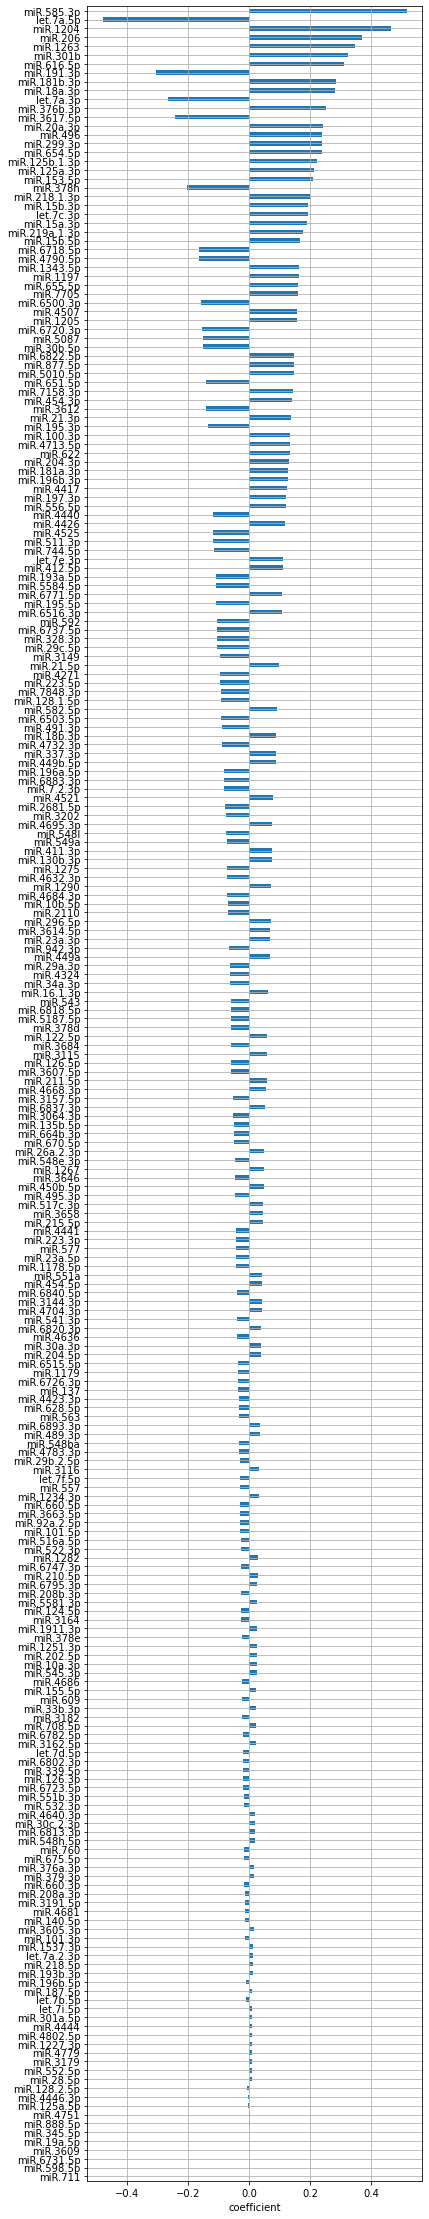

In [14]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [39]:
non_zero_coefs.abs().sort_values("coefficient", ascending=False)

,coefficient
miR.585.3p,0.517588
let.7a.5p,0.481919
miR.1204,0.463961
miR.206,0.370790
miR.1263,0.345742
...,...
miR.19a.5p,0.001228
miR.3609,0.001087
miR.6731.5p,0.000804
miR.598.5p,0.000129


---

In [22]:
coxnet = CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.4)
coxnet.fit(Xs, y)

CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.4)

In [24]:
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients'])

,coefficients
let.7a.2.3p,0.000000
let.7a.3p,0.000000
let.7a.5p,0.000000
let.7b.5p,-0.014266
let.7c.3p,0.000000
...,...
miR.96.5p,0.000000
miR.98.3p,0.000000
miR.99a.5p,0.000000
miR.99b.3p,0.000000


In [30]:
print(coxnet.score(Xs,y))

0.8976832236545569


---

## Which variable is the most predictive of OS?

In [31]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(Xs.values, y)
pd.Series(scores, index=Xs.columns).sort_values(ascending=False)

/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


miR.301b       0.765438
miR.130b.3p    0.728252
miR.15b.3p     0.711710
miR.301a.3p    0.698774
miR.18a.3p     0.697737
                 ...   
miR.3135a      0.369828
miR.8078       0.364058
miR.183.5p     0.354232
miR.3648       0.352339
miR.96.5p      0.329217
Length: 2083, dtype: float64

In [37]:
pd.DataFrame(scores, index=Xs.columns, columns=['c-index']).sort_values('c-index', ascending=False)

---

## Overlap between RFE-selected miRNAs and prognostic miRNAs by CoxNet model

In [47]:
# 324 miRNAs from RFE-CV
rfecv_df = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_rfecv_selected_features_df.csv")
rfecv_list = rfecv_df.iloc[:,2:].columns

# 39 miRNAs from RFE-CV + DE miRNAs overlap
rfecv_overlap_df = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_rfecv_overlap_features_df.csv")
rfecv_overlap_list = rfecv_overlap_df.iloc[:,2:].columns

# 100 miRNAs requested from from RFE
rfe100_df = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_rfe_100_selected_features_df.csv")
rfe100_list = rfe100_df.iloc[:,2:].columns

rfecv_list

Index(['miR-92b-3p', 'miR-22-3p', 'miR-223-5p', 'miR-223-3p', 'miR-222-5p',
       'miR-222-3p', 'miR-221-5p', 'miR-221-3p', 'miR-219a-2-3p',
       'miR-500a-3p',
       ...
       'miR-590-5p', 'miR-6511a-3p', 'miR-876-3p', 'miR-128-3p', 'miR-935',
       'miR-584-5p', 'miR-1296-5p', 'miR-551a', 'miR-615-3p', 'miR-146b-5p'],
      dtype='object', length=324)

In [55]:
# Find overlap between the two miRNA lists

# Function to intersect two lists
def intersect(lst1, lst2):
    return list(set(lst1) & set(lst2))

intersect(rfecv_overlap_list, rfe100_list)

['miR-135a-5p',
 'miR-34c-3p',
 'miR-4423-3p',
 'miR-139-5p',
 'miR-200b-3p',
 'miR-15b-3p',
 'miR-216a-5p',
 'miR-34c-5p',
 'miR-141-3p',
 'miR-200a-3p',
 'miR-141-5p',
 'miR-429',
 'miR-200c-3p',
 'miR-96-5p',
 'miR-375',
 'miR-4705',
 'miR-4423-5p',
 'miR-217',
 'miR-139-3p',
 'miR-216b-5p',
 'miR-138-5p',
 'miR-205-5p',
 'miR-31-5p',
 'miR-124-3p',
 'miR-873-5p',
 'miR-335-3p']

In [68]:
intersect(non_zero_coefs.index, rfecv_list)

[]

In [67]:
non_zero_coefs.index

Index(['let.7a.2.3p', 'let.7a.3p', 'let.7a.5p', 'let.7b.5p', 'let.7c.3p',
       'let.7d.5p', 'let.7e.3p', 'let.7f.5p', 'let.7i.5p', 'miR.100.3p',
       ...
       'miR.7158.3p', 'miR.7.2.3p', 'miR.744.5p', 'miR.760', 'miR.7705',
       'miR.7848.3p', 'miR.877.5p', 'miR.888.5p', 'miR.92a.2.5p',
       'miR.942.3p'],
      dtype='object', length=246)